# MVPA MEG Tutorial (Python)

[work in progress]

This tutorial accompanies the preprint titled "Multivariate pattern analysis for MEG: a comprehensive comparison of dissimilarity measures", which is available at [placeholder](http://doi.org/).

In this initial tutorial, we will cover SVM classification and show how to obtain 1) classification accuracy time courses, 2) representational dissimilarity matrices (RDMs), and 3) compute the intersession-reliability for RDMs.


### Preparation

The custom code for this tutorial can be downloaded as a zip file from [placeholder](https://github.com/m-guggenmos/megmvpa/blob/master/example.ipynb). This zip file includes the example dataset used for this tutorial, which can be separately downloaded from [placeholder](https://github.com/m-guggenmos/megmvpa/blob/master/example.ipynb). To reduce computational costs for the tutorial, the dataset is for one participant only and includes only 10 of 92 experimental conditions.
In addition, the zip file contains the following python files underlying the tutorial: 

File | | Description
--- | --- | ---
example.py | | _the main tutorial code_
cv.py | | _containing code for pseudo-trials/permutations/cross-validation_


The tutorial requires 4 additional python packages, which should be available in most scientific python distributions: 
* numpy
* scipy
* scikit-learn
* matplotlib

The Weighted Robust Distance classifier (WeiRD), one of the classifiers highlighted in the manuscript, is likewise included in the zip file (weird.py). If you're only interested in WeiRD or interested in the Matlab version, see [here](https://github.com/m-guggenmos/weird).

### Tutorial

We start with some imports:

In [1]:
import pickle
import os

import numpy as np
import scipy
from sklearn.svm import SVC
from sklearn.discriminant_analysis import _cov
from cv import ShuffleBinLeaveOneOut

We set a seed, in order to make analyses reproducible:

In [2]:
np.random.seed(10)

Let's load some data:

In [3]:
root = '' # This is the /path/to the directory containing the data.
          # We leave it empty here, because the data is located in the current directory.

# Load data and trial labels for the two sessions of participant 01
sessions = [
    # Session 1
    dict(
        data=pickle.load(open(os.path.join(root, 'data01_sess1_bs10.pkl'), 'rb')),
        # data has shape n_trials x n_sensors x n_timepoints
        labels=pickle.load(open(os.path.join(root, 'labels01_sess1.pkl'), 'rb'))
        # labels has shape 1 x n_trials (i.e., one condition label [object category] per trial)
    ),
    # Session 2
    dict(
        data=pickle.load(open(os.path.join(root, 'data01_sess2_bs10.pkl'), 'rb')),
        labels=pickle.load(open(os.path.join(root, 'labels01_sess2.pkl'), 'rb'))
    )
]

Now we set some parameters. Only the number of permutations and the number of pseudo-trials are free parameters. The number of conditions, sensors, time points and sessions are derived from the data (i.e., from the `sessions` variable above).

In [4]:
# Parameters
n_perm = 20  # number of permutations
n_pseudo = 5  # number of pseudo-trials
n_conditions = len(np.unique(sessions[0]['labels']))
n_sensors = sessions[0]['data'].shape[1]
n_time = sessions[0]['data'].shape[2]
n_sessions = len(sessions)

We select a Support Vector Machine as a classifier (`SVC` in scikit-learn). Examples for other classifiers are in the comments.

In [5]:
# Choose classifier
clf = SVC(kernel='linear')
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()
# from weird import WeiRD
# clf = WeiRD()

We choose our partitioning scheme, here `ShuffleBinLeaveOneOut`. This class will provide the trial-to-pseudo-trial assignments for each permutation. We'll define the class object already at this point:

In [6]:
# Choose data partitioning scheme
CV = ShuffleBinLeaveOneOut

The analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 5 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Fit the classifier to the training data
4. Predict samples from the test data
5. Compute the dissimilarity (here classification accuracy) for the current condition pair and store in RDM.

In [7]:
# pre-load mechanism, for convenience
preload_RDM = True
if preload_RDM:
    RDM = pickle.load(open(os.path.join(root, 'RDM.pkl'), 'rb'))
else:
    RDM = np.full((n_sessions, n_perm, n_conditions, n_conditions, n_time), np.nan)
    for s, session in enumerate(sessions):

        print('Session %g / %g' % (s + 1, n_sessions))

        X = session['data']
        y = session['labels']

        cv = CV(y, n_iter=n_perm, n_pseudo=n_pseudo)

        for f, (train_indices, test_indices) in enumerate(cv.split(X)):
            print('\tPermutation %g / %g' % (f + 1, n_perm))

            # 1. Compute pseudo-trials for training and test
            Xpseudo_train = np.full((len(train_indices), n_sensors, n_time), np.nan)
            Xpseudo_test = np.full((len(test_indices), n_sensors, n_time), np.nan)
            for i, ind in enumerate(train_indices):
                Xpseudo_train[i, :, :] = np.mean(X[ind, :, :], axis=0)
            for i, ind in enumerate(test_indices):
                Xpseudo_test[i, :, :] = np.mean(X[ind, :, :], axis=0)


            # 2. Whitening using the Epoch method
            sigma_conditions = cv.labels_pseudo_train[0, :, n_pseudo-1:].flatten()
            sigma_ = np.empty((n_conditions, n_sensors, n_sensors))
            for c in range(n_conditions):
                # compute sigma for each time point, then average across time
                sigma_[c] = np.mean([_cov(Xpseudo_train[sigma_conditions==c, :, t], shrinkage='auto')
                                     for t in range(n_time)], axis=0)
            sigma = sigma_.mean(axis=0)  # average across conditions
            sigma_inv = scipy.linalg.fractional_matrix_power(sigma, -0.5)
            Xpseudo_train = (Xpseudo_train.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)
            Xpseudo_test = (Xpseudo_test.swapaxes(1, 2) @ sigma_inv).swapaxes(1, 2)

            for t in range(n_time):
                for c1 in range(n_conditions-1):
                    for c2 in range(min(c1 + 1, n_conditions-1), n_conditions):
                            # 3. Fit the classifier using training data
                            data_train = Xpseudo_train[cv.ind_pseudo_train[c1, c2], :, t]
                            clf.fit(data_train, cv.labels_pseudo_train[c1, c2])

                            # 4. Compute predictions using test data
                            data_test = Xpseudo_test[cv.ind_pseudo_test[c1, c2], :, t]
                            predictions = clf.predict(data_test)

                            # 5. Compute dissimilarity and store in RDM
                            dissimilarity = np.mean(predictions == cv.labels_pseudo_test[c1, c2]) - 0.5
                            RDM[s, f, c1, c2, t] = np.mean(dissimilarity)
    # average across permutations
    RDM_av = np.nanmean(RDM, axis=1)
    pickle.dump(RDM_av, open(os.path.join(root, 'RDM.pkl'), 'wb'))

Ok, after computing the RDMs for each session and each timepoint, let's take a look at the data. For this, we use matplotlib.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's take a look at the structure of `RDM`:

In [9]:
RDM.shape

(2, 10, 10, 130)

The variable `RDM` contains a 10x10 RDM for 2 sessions and 130 time points.

In a first step, we plot the average classification accuracy time course. For this, we collapse across sessions and conditions of the RDM:

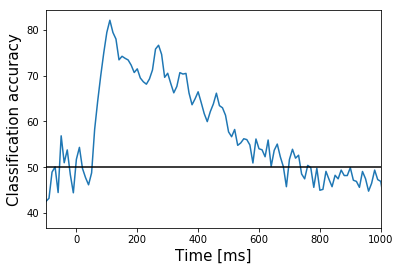

In [10]:
plt.plot(np.arange(-100, 1200, 10), 100*np.nanmean(RDM, axis=(0, 1, 2))+50)
plt.plot([-100, 1000], [50, 50], 'k-')
plt.xlim((-100, 1000))
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Classification accuracy', fontsize=15)

Looks not too bad, does it? Note that the period -100ms to 0ms is the baseline phase and stimulus onset is at 0ms. Peak classification in this example is at around 120ms, which is in the range of the group average.

In a second step, we compute the session-to-session reliability (pattern reliability and sum-of-squares[SSQ] reliability):

In [11]:
reliability_pearson = np.full(n_time, np.nan)
reliability_ssq = np.full(n_time, np.nan)
for t in range(n_time):
    d1 = RDM[0, :, :, t][np.isfinite(RDM[0, :, :, t])]
    d2 = RDM[1, :, :, t][np.isfinite(RDM[1, :, :, t])]
    reliability_pearson[t] = scipy.stats.pearsonr(d1, d2)[0]
    reliability_ssq[t] = 1 - np.sqrt(scipy.stats.stats._sum_of_squares(d1-d2)) / np.sqrt(np.sum(d1**2 + d2**2))

And plot across time:

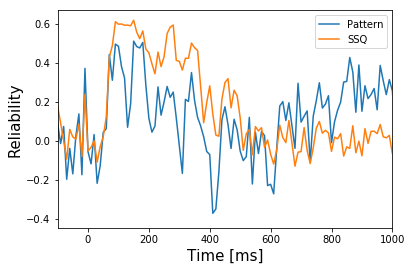

In [12]:
plt.plot(np.arange(-100, 1200, 10), reliability_pearson, label='Pattern')
plt.plot(np.arange(-100, 1200, 10), reliability_ssq, label='SSQ')
plt.xlim((-100, 1000))
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Reliability', fontsize=15)
plt.legend()

We see, that the reliability is generally more noisy compared to classification accuracy, since it is based on only two samples: session1 and session2. In addition, we can anticipate that SSQ reliability will be higher than pattern reliability for classification. In fact, the low pattern reliability is a specific problem of classification and is due to the loss of information, when computing the binary correctness of predictions.

tbc